# Prepare Environment

## Install Requirements

In [1]:
# uncomment to install libraries as necessary

#pip install tensorflow
#pip install ablang2
#pip install tensorboardX
#pip install icn3dpy
#pip install jupyterlab
#jupyterhub labextension 
#install jupyterlab_3dmol
#pip install transformers

## Import Libraries

In [2]:
# Core libraries
import os, gc
import re
import collections
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning / Data Processing libraries
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras import regularizers
import keras
import torch

# Specialized libraries (assuming these are either third-party or local)
import ablang2  
# import icn3dpy  

2024-08-07 16:24:30.895507: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 16:24:31.851337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Project Description - Need Update

## Overview

## General Steps 
To import and prepare your data for analysis with machine learning models, focusing on VH (variable heavy chain) and VL (variable light chain) sequences along with their corresponding labels, follow these structured steps:

1. Import Libraries: Include necessary libraries for data manipulation (e.g., pandas), machine learning, and any specific libraries for handling VH and VL sequences, such as ablang and ablang2 for embedding generation.
2. Load Your Data: Use pandas or a similar library to load your dataset from a CSV file or another data source. This dataset should include VH and VL sequences and their corresponding labels indicating antigen neutralization.
3. Preprocess Data: Prepare the sequence data according to the input requirements of your pretrained models (ablang and ablang2). This might involve sequence cleaning, encoding, or formatting.
4. Load Pretrained Models: Initialize ablang and ablang2 models with pretrained weights, ready to generate embeddings for your sequences.
5. Generate Embeddings: Apply the pretrained models to your preprocessed VH and VL sequences to produce embeddings. These embeddings transform the sequence data into a numerical format suitable for machine learning analysis.
6. Prepare Final Dataset: Combine the generated embeddings with the corresponding labels into a final dataset. This dataset will serve as the input for subsequent machine learning tasks, such as classification or clustering.
7. Machine Learning Analysis: Use the prepared dataset to train machine learning models, evaluate their performance, and perform predictions or exploratory data analysis.

## VH (Variable Heavy) and VL (Variable Light)
Antibodies, also known as immunoglobulins, are Y-shaped molecules composed of two identical heavy chains and two identical light chains. Each chain consists of variable (V) and constant (C) regions. The variable regions of the heavy and light chains (VH and VL, respectively) are critical for the antibody's specificity because they contain the antigen-binding site. This site binds to specific parts of an antigen, called epitopes, allowing the antibody to recognize and bind to a vast array of pathogens.

## VHH (Single Domain Antibodies)
VHH refers to a special type of antibody fragment derived from heavy-chain-only antibodies (HcAbs) found in camelids (camels, llamas, and alpacas). Unlike conventional antibodies, HcAbs do not have light chains, so their antigen-binding site consists solely of the variable domain of the heavy chain (VHH). VHH antibodies, also known as nanobodies, are much smaller than regular antibodies, which allows them to reach and bind to hidden epitopes that are inaccessible to conventional antibodies. Their small size, high stability, solubility, and ease of production in microbial systems make VHH antibodies particularly attractive for research, diagnostic, and therapeutic applications.

VHorVHH seems to contain both heavy and light weight variables. ablang2_model requires both VH and VL as input sequences to conduct embedding.

# Preprocess Data

## Import Data

In [71]:
# retrieve dataset and import to dataframe

#url = "https://opig.stats.ox.ac.uk/webapps/covabdab/static/downloads/CoV-AbDab_080224.csv"
fp = "data/CoV-AbDab_080224.csv"

df = pd.read_csv(fp)
df

,Name,Ab or Nb,Binds to,Doesn't Bind to,Neutralising Vs,Not Neutralising Vs,Protein + Epitope,Origin,VHorVHH,VL,...,Light J Gene,CDRH3,CDRL3,Structures,ABB Homology Model (if no structure),Sources,Date Added,Last Updated,Update Description,Notes/Following Up?
0,Curtis_3548_S-2,Ab,SARS-CoV2_WT;SARS-CoV2_Beta,SARS-CoV2_Omicron-BA1;HKU1,SARS-CoV2_WT (weak),NaN,S; RBD/non-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,...,ND,ARGSRNDLRDFDY,QSYNSSLSGLVV,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
1,Curtis_3548_S-7,Ab,SARS-CoV2_WT;SARS-CoV2_Beta,SARS-CoV2_Omicron-BA1;HKU1,NaN,SARS-CoV2_WT,S; non-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,...,ND,AREPYSSGMGGRDY,QQYGSSPYT,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
2,Curtis_3548_RBD-15,Ab,SARS-CoV2_WT,SARS-CoV2_Beta;SARS-CoV2_Omicron-BA1;HKU1,NaN,SARS-CoV2_WT,S; iso-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,...,ND,AKGIYSSSSYWFGP,QAWDSSTVV,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Binds only non-prefusion stabilised RBD. Complete
3,8-D9,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,S; RBD,B-cells; SARS-CoV2 Human Vaccinee (BBIBP-CorV),VQLVESGGGLVQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLEW...,DIQMTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...,...,IGKJ3 (Human),ARDHSGHALDI,QHLNSYPSMYT,https://www.rcsb.org/structure/8J1T;https://ww...,NaN,"Wanbo Tai et al., 2023 (https://www.nature.com...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
4,Sun_1G11,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,SARS-CoV2_Omicron-BQ1;SARS-CoV2_Omicron-BQ1.1;...,S; RBD,B-cells; SARS-CoV2 Human Patient,EVQLVESGGGLVQPGRSLRLSCAASGFKFDDYAMHWVRQAPGKGLE...,DIQLTQSPSFLSASVGDRVTITCRASQGIDKYLAWYQQKPGQAPKV...,...,IGKJ3 (Human),VKDSNYDSSGYLINNFDY,QQLYTFPVT,https://www.rcsb.org/structure/8IX3,NaN,"Hui Sun et al., 2023 (https://journals.asm.org...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12913,BD55-6725,Ab,SARS-CoV2_WT,NaN,NaN,SARS-CoV2_WT;SARS-CoV2_Omicron-BA1;SARS-CoV2_O...,S; RBD,SARS convalescents,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...,EIVLAQSPATLSLSPGERAILSCRASQSVNTYLAWYQQKPGQAPRL...,...,IGKJ4 (Human),ARDRFGEFIYPGALDI,QQRSNWPLT,ND,NaN,"Yunlong Cao et al., 2022 (https://www.biorxiv....","Oct 3, 2022","Dec 31, 2022",NaN,Complete
12914,BD55-6726,Ab,SARS-CoV2_WT,NaN,NaN,SARS-CoV2_WT;SARS-CoV2_Omicron-BA1;SARS-CoV2_O...,S; RBD,SARS convalescents,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...,...,IGKJ1 (Human),AAMVRGGWWYFDL,QQRSDWPWT,ND,NaN,"Yunlong Cao et al., 2022 (https://www.biorxiv....","Oct 3, 2022","Dec 31, 2022",21st Mar '23: Overwrote gene assignment from s...,Complete
12915,BD55-6727,Ab,SARS-CoV2_WT;SARS-CoV2_Omicron-BA1;SARS-CoV2_WT,NaN,SARS-CoV2_WT;SARS-CoV2_Omicron-BA1 (weak),SARS-CoV2_Omicron-BA2;SARS-CoV2_Omicron-BA2.75...,S; RBD,SARS convalescents,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...,...,IGKJ2 (Human),ASDPGGLSELAAEYFHH,QQSHSTPYT,ND,NaN,"Yunlong Cao et al., 2022 (https://www.biorxiv....","Oct 3, 2022","Dec 31, 2022",NaN,Complete
12916,BD55-6728,Ab,SARS-CoV2_WT,NaN,NaN,SARS-CoV2_WT;SARS-CoV2_Omicron-BA1;SARS-CoV2_O...,S; RBD,SARS convalescents,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...,...,IGKJ1 (Human),ARESTEVTHWYFDL,QQSYVTPEYT,ND,NaN,"Yunlong Cao et al., 2022 (https://www.biorxiv....","Oct 3, 2022","Dec 31, 2022",NaN,Complete


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12918 entries, 0 to 12917
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Name                                  12918 non-null  object 
 1   Ab or Nb                              12918 non-null  object 
 2   Binds to                              12918 non-null  object 
 3   Doesn't Bind to                       3201 non-null   object 
 4   Neutralising Vs                       6373 non-null   object 
 5   Not Neutralising Vs                   5482 non-null   object 
 6   Protein + Epitope                     12914 non-null  object 
 7   Origin                                12913 non-null  object 
 8   VHorVHH                               12918 non-null  object 
 9   VL                                    12112 non-null  object 
 10  Heavy V Gene                          12918 non-null  object 
 11  Heavy J Gene   

## Clean Data

In [73]:
# keep columns for data cleaning
cols_for_analysis = ['Name','Origin', 'Neutralising Vs', 'CDRH3', 'CDRL3', 'VHorVHH', 'VL']
df_ML = df[cols_for_analysis]

# keep records of human origin, filter column "Origin" that
## contains the case-insensitive string "human," and
## is not NaN
df_ML = df_ML[df_ML['Origin'].str.lower().str.contains('human').fillna(False)]

# define binary label isNeurtalising
df_ML.loc[:,'isNeutralising'] = 0
df_ML.loc[:,'isNeutralising'] = df_ML['Neutralising Vs'].apply(lambda x: 0 if pd.isna(x) else 1)

df_ML.head(5)

/tmp/ipykernel_60561/254585956.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ML = df_ML[df_ML['Origin'].str.lower().str.contains('human').fillna(False)]


,Name,Origin,Neutralising Vs,CDRH3,CDRL3,VHorVHH,VL,isNeutralising
0,Curtis_3548_S-2,B-cells; SARS-CoV2 Human Patient,SARS-CoV2_WT (weak),ARGSRNDLRDFDY,QSYNSSLSGLVV,ND,ND,1
1,Curtis_3548_S-7,B-cells; SARS-CoV2 Human Patient,NaN,AREPYSSGMGGRDY,QQYGSSPYT,ND,ND,0
2,Curtis_3548_RBD-15,B-cells; SARS-CoV2 Human Patient,NaN,AKGIYSSSSYWFGP,QAWDSSTVV,ND,ND,0
3,8-D9,B-cells; SARS-CoV2 Human Vaccinee (BBIBP-CorV),SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,ARDHSGHALDI,QHLNSYPSMYT,VQLVESGGGLVQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLEW...,DIQMTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...,1
4,Sun_1G11,B-cells; SARS-CoV2 Human Patient,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,VKDSNYDSSGYLINNFDY,QQLYTFPVT,EVQLVESGGGLVQPGRSLRLSCAASGFKFDDYAMHWVRQAPGKGLE...,DIQLTQSPSFLSASVGDRVTITCRASQGIDKYLAWYQQKPGQAPKV...,1


In [74]:
# Vocab copied from the ablang2
ablang_vocab = {
    "<": 0,    # Start token
    "-": 21,   # Padding token
    ">": 22,   # End token
    "*": 23,   # Mask token
    "X": 24,   # Unknown (residue) token
    "|": 25,   # Separation (of heavy and light chain) token
    "M": 1, 
    "R": 2, 
    "H": 3, 
    "K": 4, 
    "D": 5, 
    "E": 6, 
    "S": 7, 
    "T": 8, 
    "N": 9, 
    "Q": 10, 
    "C": 11,
    "G": 12, 
    "P": 13, 
    "A": 14, 
    "V": 15, 
    "I": 16, 
    "F": 17, 
    "Y": 18, 
    "W": 19, 
    "L": 20
}

"[{}]+".format("".join(ablang_vocab.keys()))

'[<->*X|MRHKDESTNQCGPAVIFYWL]+'

In [75]:
# Clean "CDRH3" and "CDRL3" columns

## check for valid patterns
pattern_valid = "[{}]+".format("".join(ablang_vocab.keys()))
df_ML['CDRH3'] = df_ML['CDRH3'].apply(lambda x: np.NaN if x == 'ND' else x)
df_ML['CDRL3'] = df_ML['CDRL3'].apply(lambda x: np.NaN if x == 'ND' else x)
df_ML = df_ML[df_ML['CDRH3'].fillna(' ').str.match(pattern_valid)]
df_ML = df_ML[df_ML['CDRL3'].fillna(' ').str.match(pattern_valid)]

## remove white spaces in sequence
df_ML['CDRH3'] = df_ML['CDRH3'].apply(lambda x: x.replace(" ", ""))
df_ML['CDRL3'] = df_ML['CDRL3'].apply(lambda x: x.replace(" ", ""))

## group CDRH3 and CDRL3 pairs in list format
df_ML.loc[:, 'seq_cdr3'] = df_ML[['CDRH3', 'CDRL3']] \
                        .fillna("") \
                        .apply(lambda x: [x['CDRH3'], x['CDRL3']], axis=1)

df_ML

,Name,Origin,Neutralising Vs,CDRH3,CDRL3,VHorVHH,VL,isNeutralising,seq_cdr3
0,Curtis_3548_S-2,B-cells; SARS-CoV2 Human Patient,SARS-CoV2_WT (weak),ARGSRNDLRDFDY,QSYNSSLSGLVV,ND,ND,1,"[ARGSRNDLRDFDY, QSYNSSLSGLVV]"
1,Curtis_3548_S-7,B-cells; SARS-CoV2 Human Patient,NaN,AREPYSSGMGGRDY,QQYGSSPYT,ND,ND,0,"[AREPYSSGMGGRDY, QQYGSSPYT]"
2,Curtis_3548_RBD-15,B-cells; SARS-CoV2 Human Patient,NaN,AKGIYSSSSYWFGP,QAWDSSTVV,ND,ND,0,"[AKGIYSSSSYWFGP, QAWDSSTVV]"
3,8-D9,B-cells; SARS-CoV2 Human Vaccinee (BBIBP-CorV),SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,ARDHSGHALDI,QHLNSYPSMYT,VQLVESGGGLVQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLEW...,DIQMTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...,1,"[ARDHSGHALDI, QHLNSYPSMYT]"
4,Sun_1G11,B-cells; SARS-CoV2 Human Patient,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,VKDSNYDSSGYLINNFDY,QQLYTFPVT,EVQLVESGGGLVQPGRSLRLSCAASGFKFDDYAMHWVRQAPGKGLE...,DIQLTQSPSFLSASVGDRVTITCRASQGIDKYLAWYQQKPGQAPKV...,1,"[VKDSNYDSSGYLINNFDY, QQLYTFPVT]"
...,...,...,...,...,...,...,...,...,...
11173,ZWD12,B-cells (SARS-CoV2 Vaccinated Human),SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,VKDRTDWELIRGYFGH,QQRIIWPPYT,EVQLVESGGGLVQPGGTLRLSCVASGFSFSNYWMSWVRQAPGKGLE...,DIVMTQTPSSLSLSPGDRATLSCRASENIINYLAWYQQRPGQSPRL...,1,"[VKDRTDWELIRGYFGH, QQRIIWPPYT]"
11174,ZWC12,B-cells (SARS-CoV2 Vaccinated Human),SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,AKGELLWFGDLLHNWFDP,QQYDSWPGT,EVQLVESGGALVQPGGSLRLSCAASGFTFANYAMSWVRQAPGKGLE...,DIQMTQSPFSLSVSPGERATLSCRASQSVSTNLAWYQQKPGQAPRL...,1,"[AKGELLWFGDLLHNWFDP, QQYDSWPGT]"
11175,ZWD11,B-cells (SARS-CoV2 Vaccinated Human),SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,ARDQADYYYGSGCIV,QQYSNTPLT,EVQLVESGAEVRKPGASVKLSCKASGYTFTSYYIHWVRQAPGQGLE...,DIQMTQSPATLAVSLGERATINCKSSQSVFYTSNNKNYLAWYQQKP...,1,"[ARDQADYYYGSGCIV, QQYSNTPLT]"
11176,ZWC10,B-cells (SARS-CoV2 Vaccinated Human),NaN,ARDEQKDRAMVTLPDY,QQSYNTPPWT,EVQLVESGGGVVQPGRSLRLSCAASGFTFSAYGVHWVRQAPGKGLE...,AIRMTQSPASLSASVGDRITITCRASQSISSYLNWYQHKPGKAPKL...,0,"[ARDEQKDRAMVTLPDY, QQSYNTPPWT]"


In [76]:
df_ML.columns

Index(['Name', 'Origin', 'Neutralising Vs', 'CDRH3', 'CDRL3', 'VHorVHH', 'VL',
       'isNeutralising', 'seq_cdr3'],
      dtype='object')

In [77]:
## show only necessary columns moving forward
cols=['Name', 'seq_cdr3', 'isNeutralising']
df_ML[cols]

,Name,seq_cdr3,isNeutralising
0,Curtis_3548_S-2,"[ARGSRNDLRDFDY, QSYNSSLSGLVV]",1
1,Curtis_3548_S-7,"[AREPYSSGMGGRDY, QQYGSSPYT]",0
2,Curtis_3548_RBD-15,"[AKGIYSSSSYWFGP, QAWDSSTVV]",0
3,8-D9,"[ARDHSGHALDI, QHLNSYPSMYT]",1
4,Sun_1G11,"[VKDSNYDSSGYLINNFDY, QQLYTFPVT]",1
...,...,...,...
11173,ZWD12,"[VKDRTDWELIRGYFGH, QQRIIWPPYT]",1
11174,ZWC12,"[AKGELLWFGDLLHNWFDP, QQYDSWPGT]",1
11175,ZWD11,"[ARDQADYYYGSGCIV, QQYSNTPLT]",1
11176,ZWC10,"[ARDEQKDRAMVTLPDY, QQSYNTPPWT]",0


# Generate embeddings

## What are embeddings?
Loading a pretrained model to perform embedding on antibody sequences involves converting the string representation of these sequences (which consists of amino acid characters) into a numerical format that machine learning models can process. 

- How Embedding Works
Pretrained Models: A pretrained model, such as ablang or ablang2 mentioned earlier, is typically a deep learning model that has been previously trained on a large dataset of antibody sequences. During its training, the model learns to capture the complex patterns and relationships between the amino acids in these sequences, effectively understanding the biological significance behind different sequence motifs and structures.

- Sequence to Numerical Representation: When you pass an antibody sequence to such a pretrained model, the model processes the sequence and converts it into a high-dimensional vector (or array) of numbers. This vector is called an "embedding". The embedding process captures the essential features of the sequence, such as the presence of certain motifs or the overall sequence structure, in a form that is useful for further computational analysis.

## Encode sequence (generate embedding)

In [78]:
# check for gpu availability and count cores
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    num_cpu = min(8, torch.cuda.device_count())
else:
    num_cpu = min(8, os.cpu_count())

In [79]:
# load Ablang2 model to create embedding the sequence
# https://github.com/TobiasHeOl/AbLang2

# instantiate ablang2 model
ablang2_model = ablang2.pretrained(model_to_use='ablang2-paired', random_init=False, ncpu=num_cpu, device=device)

/opt/jupyterhub/lib/python3.10/site-packages/ablang2/load_model.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


### CDR3 HL

In [80]:
df_ML['seq_cdr3'].dropna()

0          [ARGSRNDLRDFDY, QSYNSSLSGLVV]
1            [AREPYSSGMGGRDY, QQYGSSPYT]
2            [AKGIYSSSSYWFGP, QAWDSSTVV]
3             [ARDHSGHALDI, QHLNSYPSMYT]
4        [VKDSNYDSSGYLINNFDY, QQLYTFPVT]
                      ...               
11173     [VKDRTDWELIRGYFGH, QQRIIWPPYT]
11174    [AKGELLWFGDLLHNWFDP, QQYDSWPGT]
11175       [ARDQADYYYGSGCIV, QQYSNTPLT]
11176     [ARDEQKDRAMVTLPDY, QQSYNTPPWT]
11177       [ARELDYYGSGSYPDY, QTWGAAVWV]
Name: seq_cdr3, Length: 8945, dtype: object

In [81]:
# encode "seq" column (list of paired H and L sequences)
## consider using a collator if the dataset is large

# generate embeddings
seq_embeddings_cdr3 = ablang2_model(df_ML['seq_cdr3'], mode='seqcoding')
seq_embeddings_cdr3

array([[-0.06482342, -0.26118073, -0.30277974, ...,  0.41981305,
        -0.13399723,  0.2194267 ],
       [-0.12651186, -0.0098996 , -0.26401642, ...,  0.37764497,
        -0.08505214,  0.16721512],
       [-0.07043607, -0.15615954, -0.2169279 , ...,  0.39137123,
        -0.16601669,  0.20430324],
       ...,
       [-0.05386538,  0.00148973, -0.32013876, ...,  0.37828877,
        -0.18918992,  0.22630764],
       [-0.10474511, -0.03616413, -0.26576774, ...,  0.35388365,
        -0.16938038,  0.17613295],
       [ 0.01285474, -0.08284647, -0.23224622, ...,  0.25082452,
        -0.10276332,  0.13823575]])

### VHVHH VL

## PCA
Principal Component Analysis can be used to reduce the dimension of the embeddings.

In [51]:
# Perform PCA with the desired number of components (let's say 2 components for visualization)
num_components = 2
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(seq_embeddings)
pca_result

array([[-0.60026427, -0.62388239],
       [ 0.28780931, -1.17396957],
       [-0.61517396, -1.15546869],
       ...,
       [ 0.2814681 , -0.32470453],
       [ 0.37308703, -0.29811258],
       [ 0.64438755, -1.56749295]])

In [52]:
df_ML[cols]

,Name,seq,isNeutralising
0,Curtis_3548_S-2,"[ARGSRNDLRDFDY, QSYNSSLSGLVV]",1
1,Curtis_3548_S-7,"[AREPYSSGMGGRDY, QQYGSSPYT]",0
2,Curtis_3548_RBD-15,"[AKGIYSSSSYWFGP, QAWDSSTVV]",0
3,8-D9,"[ARDHSGHALDI, QHLNSYPSMYT]",1
4,Sun_1G11,"[VKDSNYDSSGYLINNFDY, QQLYTFPVT]",1
...,...,...,...
11173,ZWD12,"[VKDRTDWELIRGYFGH, QQRIIWPPYT]",1
11174,ZWC12,"[AKGELLWFGDLLHNWFDP, QQYDSWPGT]",1
11175,ZWD11,"[ARDQADYYYGSGCIV, QQYSNTPLT]",1
11176,ZWC10,"[ARDEQKDRAMVTLPDY, QQSYNTPPWT]",0


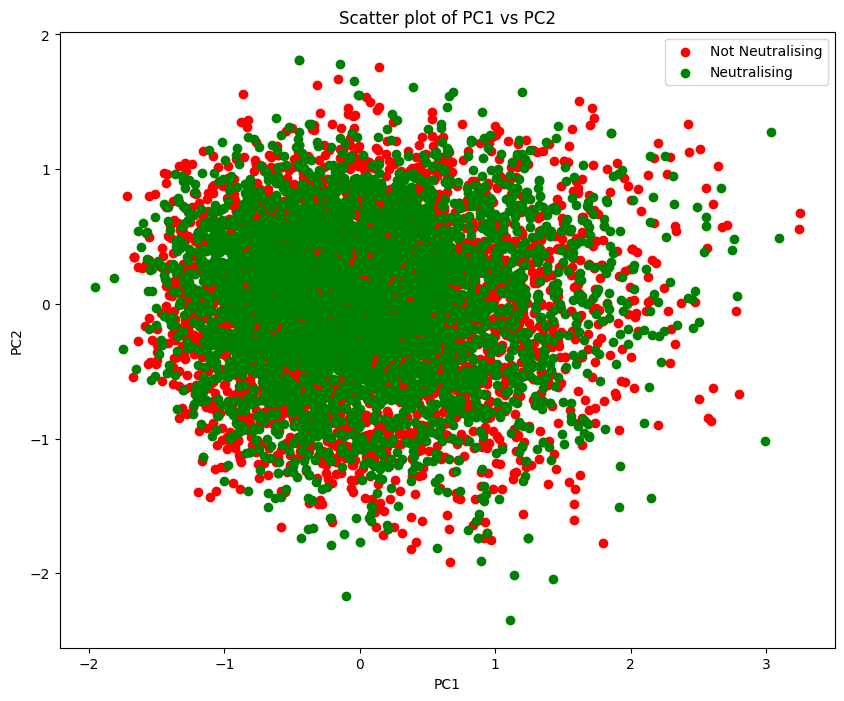

In [53]:
# Create a DataFrame to store the PCA results
df_pca = pd.DataFrame(data=pca_result, columns=[f'PC{i + 1}' for i in range(num_components)])
df_pca['isNeutralising'] = df_ML['isNeutralising']

# # Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'][df_pca['isNeutralising'] == 0], 
            df_pca['PC2'][df_pca['isNeutralising'] == 0], 
            color='r', 
            label='Not Neutralising')

plt.scatter(df_pca['PC1'][df_pca['isNeutralising'] == 1], 
            df_pca['PC2'][df_pca['isNeutralising'] == 1], 
            color='g', 
            label='Neutralising')

plt.title('Scatter plot of PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Explore Data
First we can compare the distibution of those data related to binidng and non binding and see if there is a different between them
We can use simple box plot or even PC to check it.

isNeutralising
0    4845
1    4150
Name: isNeutralising, dtype: int64


<Axes: >

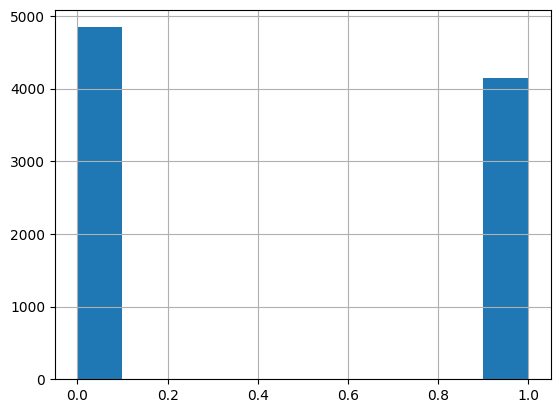

In [14]:
# check label balance
print(df_ML.groupby('isNeutralising')['isNeutralising'].count())
df_ML['isNeutralising'].hist()

<Axes: >

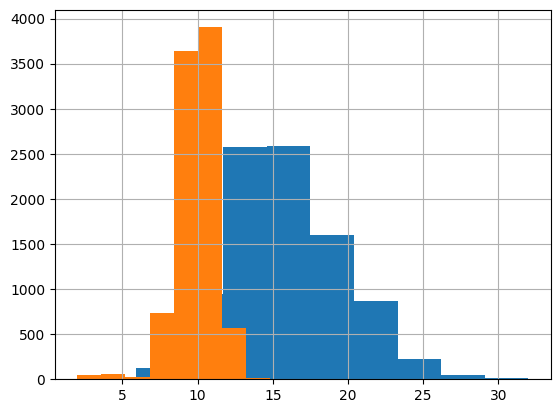

In [15]:
# Check length of 
df_ML['seq'].apply(lambda x: len(x[0])).hist() # blue, CDRH
df_ML['seq'].apply(lambda x: len(x[1])).hist() #orange

In [16]:
df_ML.columns

Index(['Name', 'Origin', 'Neutralising Vs', 'CDRH3', 'CDRL3', 'VHorVHH', 'VL',
       'isNeutralising', 'seq'],
      dtype='object')

In [17]:
# Check amino acid frequency
counter_CDRH3 = collections.Counter(df_ML['seq'].apply(lambda x: x[0]).sum())
num_total_aa = sum(counter_CDRH3.values())

print("CDRH3")
{k:round(v/num_total_aa,5) for k, v in counter_CDRH3.items()}

CDRH3


{'A': 0.10167,
 'R': 0.072,
 'G': 0.11258,
 'S': 0.07412,
 'N': 0.02123,
 'D': 0.11239,
 'L': 0.04362,
 'F': 0.05822,
 'Y': 0.12539,
 'E': 0.02296,
 'P': 0.03862,
 'M': 0.01963,
 'K': 0.01586,
 'I': 0.0274,
 'W': 0.02296,
 'H': 0.01714,
 'V': 0.0533,
 'T': 0.0383,
 'C': 0.01078,
 'Q': 0.01184}

In [18]:
# Check amino acid frequency
counter_CDRL3 = collections.Counter(df_ML['seq'].apply(lambda x: x[0]).sum())
num_total_aa = sum(counter_CDRL3.values())

print("CDRL3")
{k:round(v/num_total_aa,5) for k, v in counter_CDRL3.items()}

CDRL3


{'A': 0.10167,
 'R': 0.072,
 'G': 0.11258,
 'S': 0.07412,
 'N': 0.02123,
 'D': 0.11239,
 'L': 0.04362,
 'F': 0.05822,
 'Y': 0.12539,
 'E': 0.02296,
 'P': 0.03862,
 'M': 0.01963,
 'K': 0.01586,
 'I': 0.0274,
 'W': 0.02296,
 'H': 0.01714,
 'V': 0.0533,
 'T': 0.0383,
 'C': 0.01078,
 'Q': 0.01184}

In [19]:
# Simple correlation between sequence length and neutralising status
df_ML['len_CDRH3'] = df_ML['seq'].apply(lambda x: len(x[0]))
df_ML['len_CDRL3'] = df_ML['seq'].apply(lambda x: len(x[1]))
print(df_ML[['len_CDRH3', 'len_CDRL3', 'isNeutralising']].corr())

                len_CDRH3  len_CDRL3  isNeutralising
len_CDRH3        1.000000   0.059128        0.014174
len_CDRL3        0.059128   1.000000        0.048349
isNeutralising   0.014174   0.048349        1.000000


Text(0.5, 1.0, 'Sequence Length Distribution')

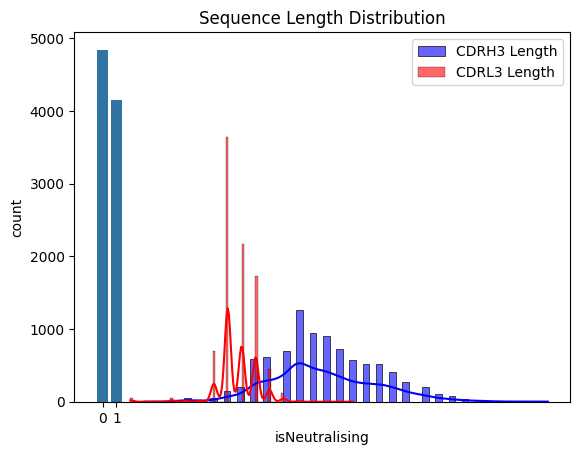

In [20]:
# Class balance
sns.countplot(x='isNeutralising', data=df_ML)
plt.title('Class Distribution')

# Sequence length distribution
sns.histplot(data=df_ML, x='len_CDRH3', color='blue', kde=True, label='CDRH3 Length', alpha=0.6)
sns.histplot(data=df_ML, x='len_CDRL3', color='red', kde=True, label='CDRL3 Length', alpha=0.6)
plt.legend()
plt.title('Sequence Length Distribution')

# Compare Models
For binary classification tasks, initiating the modeling process with a simple logistic regression model before progressing to more complex architectures like neural networks (NN) or fully connected (FC) models is a practical approach.

Here’s an expanded view on developing a robust machine learning model, incorporating both simple and complex methodologies:

- Initial Simple Model: Starting with logistic regression is beneficial due to its simplicity, interpretability, and efficiency in training. This step allows for a preliminary assessment of the dataset's characteristics and the feasibility of achieving meaningful classification.
- Progression to Complex Models: After evaluating the performance of the logistic regression model, transitioning to a neural network or a fully connected model can offer deeper insights and potentially improved accuracy. These complex models are capable of capturing nonlinear relationships and interactions within the data.

When developing these models, consider several important factors:

Data Imbalance: Acknowledge the presence of data imbalance and its potential effects on model performance.
Balancing the Dataset: Employ appropriate techniques to balance the dataset, such as resampling methods, to ensure equitable representation of classes.
Balancing the Dataset: Employ appropriate techniques to balance the dataset, such as resampling methods, to ensure equitable representation of classes.
Data Division: Strategically divide the data into training, validation, and testing sets. Utilize the training and validation sets for fine-tuning the hyperparameters of the models.


In [49]:
# Set the random seeds for numpy and tensorflow to ensure reproducible results
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
# This split ensures balanced classes in the train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    seq_embeddings_cdr3, df_ML['isNeutralising'], test_size=0.1, random_state=0, stratify=df_ML['isNeutralising']
)

In [23]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### logistic Regression model 

In [24]:
# Initialize an empty DataFrame to store simplified metrics
metrics_df = pd.DataFrame(columns=['Model','Accuracy', 'f1_Score'])

In [25]:
# Create and train the Logistic Regression model
model = LogisticRegression(max_iter=1000, C=1.0)
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)

# # Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # Ensure average='binary' for binary classification
new_row = {'Model': 'LogisticRegression', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
print(f'Accuracy: {accuracy}')
print(f'f1_score: {f1}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6222222222222222
f1_score: 0.5728643216080402
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       485
           1       0.60      0.55      0.57       415

    accuracy                           0.62       900
   macro avg       0.62      0.62      0.62       900
weighted avg       0.62      0.62      0.62       900



/tmp/ipykernel_48110/247066646.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)


In [26]:
metrics_df

,Model,Accuracy,f1_Score
0,LogisticRegression,0.622222,0.572864


### A NN model 

In [27]:
# set parameters:
n_epochs = 20
batch_size = 50

In [28]:
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=6, activation='relu'),
    tf.keras.layers.Dense(units=6, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# Compiling the ANN
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

2024-08-07 15:53:51.576699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-07 15:53:51.577670: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [29]:
# Training the ANN on the Training set
history = ann.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5050 - loss: 0.7190 - val_accuracy: 0.5435 - val_loss: 0.6889
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5623 - loss: 0.6794 - val_accuracy: 0.5639 - val_loss: 0.6812
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5824 - loss: 0.6673 - val_accuracy: 0.5701 - val_loss: 0.6762
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5926 - loss: 0.6580 - val_accuracy: 0.5825 - val_loss: 0.6716
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5999 - loss: 0.6499 - val_accuracy: 0.5818 - val_loss: 0.6696
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6165 - loss: 0.6427 - val_accuracy: 0.5874 - val_loss: 0.6654
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6259 - loss: 0.6355 - val_accuracy: 0.5923 - val_loss: 0.6623
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6333 - loss: 0.6276 - val_accuracy: 0.

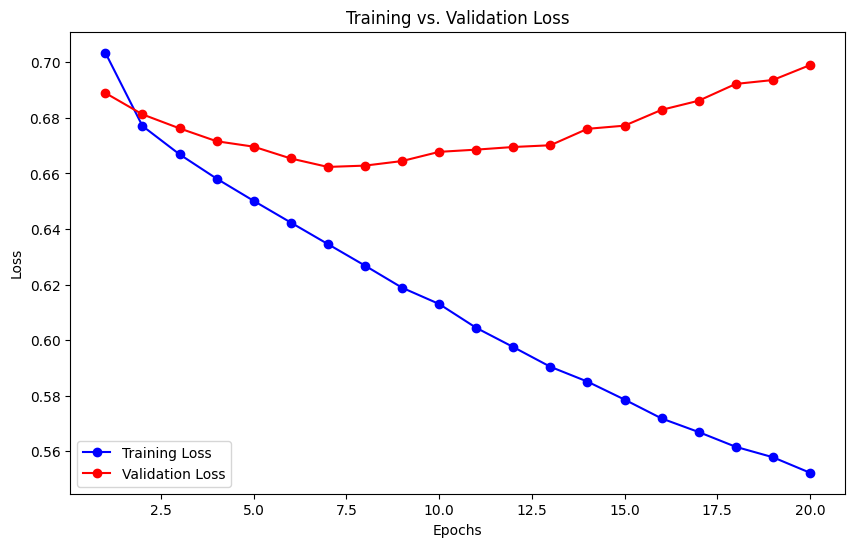

In [30]:
# Extracting loss and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### How should we interpert this plot?

1. Training Loss vs. Validation Loss:
- The training loss measures how well the model is fitting the training data. As the training progresses (more epochs), the model learns and the training loss typically decreases.
- The validation loss measures how well the model performs on a separate set of data not seen during training, giving an indication of how well the model generalizes.

2. Interpretation of the Loss Trends:
- Initially, both training and validation losses decrease, which is good—it means the model is learning and generalizing well.
- However, after a certain number of epochs, the validation loss stops decreasing and starts to fluctuate or even increase slightly while the training loss continues to decrease. This is a classic sign of overfitting.

3. Overfitting:
- Overfitting occurs when the model learns the training data too well, including noise and details that do not generalize to new data. It's like memorizing the answers instead of understanding the subject.
- In the plot, overfitting is suggested because the model's loss on the validation set is no longer decreasing alongside the training loss. The model is improving on the training data but not on the validation data.

### Improving the Model:
- Early Stopping: Implement early stopping to terminate the training process when the validation loss stops decreasing, preventing overfitting by not allowing the model to train excessively.
- Regularization: Introduce regularization methods like L1 or L2 regularization to constrain the magnitude of the model weights, which can discourage overfitting by imposing complexity penalties on the model's loss function.
- Dropout: Add dropout layers to the neural network architecture to introduce regularization by randomly setting a fraction of the input units to 0 at each update during training, which can help prevent overfitting.
- Data Augmentation: Employ data augmentation techniques to synthetically expand the training dataset by applying random, yet realistic, transformations to the training data. This can lead to a model that generalizes better.
- Reduce Model Complexity: Simplify the model's architecture by reducing the number of layers or the number of neurons in each layer if the model is too complicated and overfitting the training data.
- Adjust Learning Rate and Batch Size: Fine-tune the learning rate and batch size to control the training dynamics. A learning rate that's too high can cause the model to converge too quickly to suboptimal solutions, whereas one that's too low can slow down the training process. Similarly, an appropriate batch size can balance between computational efficiency and the regularizing effect of stochasticity in the gradient descent.
- Perform Hyperparameter Tuning: Run systematic experiments to find the best model parameters, including the learning rate, batch size, and other model-specific hyperparameters. This can be done using techniques like grid search or random search, or more sophisticated methods like Bayesian optimization. By tuning hyperparameters, you can potentially improve the model's performance and robustness.
    
For beginners, it's important to monitor both training and validation loss and look for signs of overfitting. Interventions like those mentioned above can help ensure that your model learns to generalize well, rather than just memorizing the training dataset.

In [31]:
# Predict the labels for the test set
predictions_prob = ann.predict(X_test)

# Assuming `predictions` are the output probabilities from your model
y_pred = (predictions_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # Ensure average='binary' for binary classification
new_row = {'Model': 'nn_shallow', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
print(f'Accuracy: {accuracy}')
print(f'f1_score: {f1}')
print(classification_report(y_test, y_pred))
metrics_df

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.5788888888888889
f1_score: 0.49933949801849403
              precision    recall  f1-score   support

           0       0.59      0.68      0.64       485
           1       0.55      0.46      0.50       415

    accuracy                           0.58       900
   macro avg       0.57      0.57      0.57       900
weighted avg       0.58      0.58      0.57       900



,Model,Accuracy,f1_Score
0,LogisticRegression,0.622222,0.572864
1,nn_shallow,0.578889,0.499339


The original model is a simple neural network with two hidden layers, each consisting of 6 units. This design may be too simplistic, especially if the input dimensionality is high (e.g., 480 features). With only 6 units in each layer, the model may not have enough capacity to learn complex patterns in the data, which could lead to underfitting.

Increased Layer Units:
- The proposed model begins with a significantly larger number of units (240) in the first hidden layer. Starting with more units can help the model capture a wide variety of patterns and relationships in the data, given the high dimensionality of the inputs.
-mGradually decreasing the number of units in subsequent layers (from 240 to 120, then 60, and finally 30) before reaching the output layer allows the model to refine and distill these patterns into more abstract representations. This approach is akin to funneling the information in a controlled manner, which can be particularly effective in learning from a large number of features.

Regularization:
- Regularization is applied to each layer in the form of L2 regularization with a factor of 0.01. L2 regularization penalizes the weights' magnitudes by adding a term to the loss function proportional to the sum of the squared weights. This encourages the model to keep the weights small, which can help prevent overfitting by discouraging the model from relying too heavily on any single feature or combination of features.
- Regularization can be crucial when increasing the number of units in the layers as it helps to maintain the generalization ability of the model despite the added complexity.

Learning rate:
- Adjusting the learning rate to 0.001 for better performance. A smaller learning rate can make the optimization process more gradual and precise, potentially leading to better convergence on a minimum of the loss function.


While the proposed model has the potential to learn complex patterns better, it is also more prone to overfitting due to its increased capacity. Therefore, it is essential to monitor the model's performance on both training and validation datasets and consider implementing additional strategies such as dropout, early stopping, or further hyperparameter tuning to find the optimal model configuration.

In [32]:
# Define the model architecture
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=240, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=60, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# Compiling the ANN
ann.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
# Training the ANN on the Training set
history = ann.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5555 - loss: 4.6798 - val_accuracy: 0.5645 - val_loss: 1.2771
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5740 - loss: 1.0583 - val_accuracy: 0.5578 - val_loss: 0.7584
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5649 - loss: 0.7410 - val_accuracy: 0.5503 - val_loss: 0.7033
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5601 - loss: 0.7033 - val_accuracy: 0.5608 - val_loss: 0.6927
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5549 - loss: 0.6954 - val_accuracy: 0.5683 - val_loss: 0.6893
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5564 - loss: 0.6926 - val_accuracy: 0.5683 - val_loss: 0.6875
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5579 - loss: 0.6912 - val_accuracy: 0.5763 - val_loss: 0.6861
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5670 - loss: 0.6906 - val_accuracy: 0.

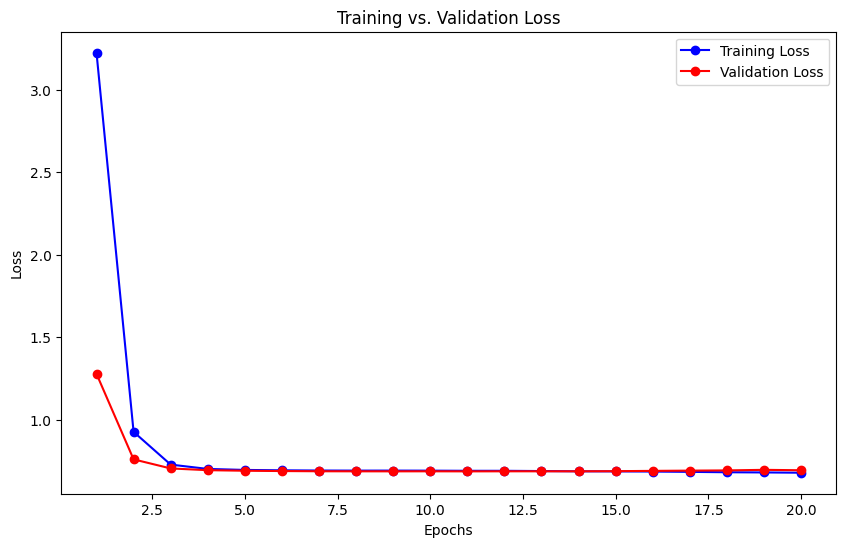

In [34]:
# Extracting loss and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Predict the labels for the test set
predictions_prob = ann.predict(X_test)

# Assuming `predictions` are the output probabilities from your model
y_pred = (predictions_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # Ensure average='binary' for binary classification
new_row = {'Model': 'nn_deep', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
print(f'Accuracy: {accuracy}')
print(f'f1_score: {f1}')
print(classification_report(y_test, y_pred))
metrics_df

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.6111111111111112
f1_score: 0.55470737913486
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       485
           1       0.59      0.53      0.55       415

    accuracy                           0.61       900
   macro avg       0.61      0.60      0.60       900
weighted avg       0.61      0.61      0.61       900



,Model,Accuracy,f1_Score
0,LogisticRegression,0.622222,0.572864
1,nn_shallow,0.578889,0.499339
2,nn_deep,0.611111,0.554707


### balancing data using weight adjustment 

In [36]:
# let's improve the model by adjusting the weight of low sample data.
# Calculate class weights
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

In [37]:
class_weights

{0: 0.9283256880733946, 1: 1.0836680053547523}

In [38]:
# Define the model architecture
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=240, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=60, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# Compiling the ANN
ann.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [39]:
# Training the ANN on the Training set with class weight adjustment
history = ann.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, class_weight=class_weights)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5351 - loss: 4.6019 - val_accuracy: 0.5627 - val_loss: 1.2222
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5587 - loss: 1.0233 - val_accuracy: 0.5695 - val_loss: 0.7543
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5536 - loss: 0.7391 - val_accuracy: 0.5670 - val_loss: 0.7058
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5562 - loss: 0.7063 - val_accuracy: 0.5707 - val_loss: 0.6960
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5554 - loss: 0.6992 - val_accuracy: 0.5750 - val_loss: 0.6925
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5570 - loss: 0.6968 - val_accuracy: 0.5750 - val_loss: 0.6908
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5603 - loss: 0.6953 - val_accuracy: 0.5775 - val_loss: 0.6891
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5649 - loss: 0.6938 - val_accuracy: 0.

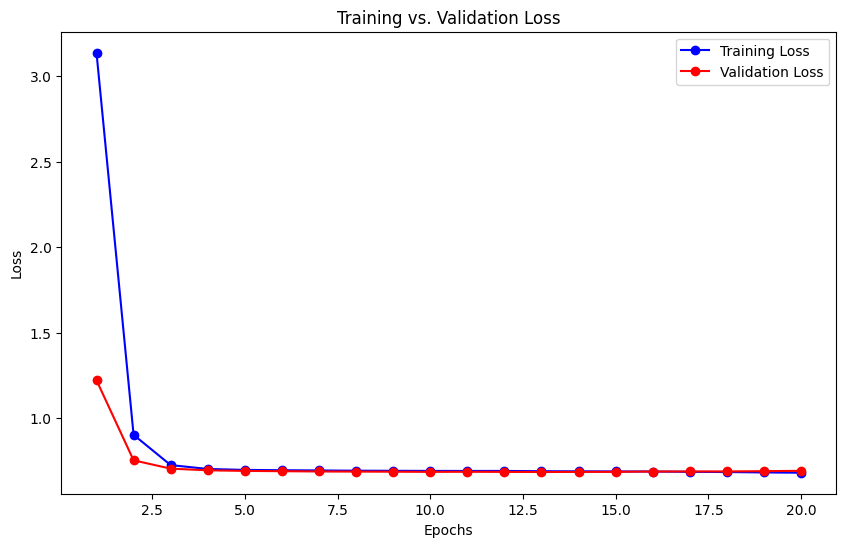

In [40]:
# Extracting loss and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
# Predict the labels for the test set
predictions_prob = ann.predict(X_test)

# Assuming `predictions` are the output probabilities from your model
y_pred = (predictions_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # Ensure average='binary' for binary classification
new_row = {'Model': 'nn_deep_weighted', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
print(f'Accuracy: {accuracy}')
print(f'f1_score: {f1}')
print(classification_report(y_test, y_pred))
metrics_df

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.58
f1_score: 0.6142857142857143
              precision    recall  f1-score   support

           0       0.66      0.46      0.54       485
           1       0.53      0.73      0.61       415

    accuracy                           0.58       900
   macro avg       0.60      0.59      0.58       900
weighted avg       0.60      0.58      0.57       900



,Model,Accuracy,f1_Score
0,LogisticRegression,0.622222,0.572864
1,nn_shallow,0.578889,0.499339
2,nn_deep,0.611111,0.554707
3,nn_deep_weighted,0.580000,0.614286


In [42]:
# Define the K-fold cross validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Lists to store results of each fold
all_y_test = []
all_y_pred = []

# K-fold Cross Validation model evaluation
fold_no = 1
X= X_train
y = y_train
for train, test in kfold.split(X, y):

    # Define the model architecture
    ann = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=240, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(units=60, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

    # Compile the model
    ann.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
  
    # Fit the model
    print(f'Training for fold {fold_no} ...')
    ann.fit(X[train], y[train], batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(X[test], y[test]))
    
    # Generate predictions
    y_pred = model.predict(X[test])
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Store the true labels and predictions
    all_y_test.extend(y[test])
    all_y_pred.extend(y_pred_binary.flatten())  # Flatten to ensure it's a 1D array

    # Increase fold number
    fold_no += 1

Training for fold 1 ...
Epoch 1/20


/opt/jupyterhub/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5528 - loss: 4.5893 - val_accuracy: 0.5547 - val_loss: 1.2124
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5631 - loss: 1.0128 - val_accuracy: 0.5503 - val_loss: 0.7509
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5525 - loss: 0.7344 - val_accuracy: 0.5633 - val_loss: 0.7045
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5558 - loss: 0.7025 - val_accuracy: 0.5608 - val_loss: 0.6951
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5648 - loss: 0.6954 - val_accuracy: 0.5534 - val_loss: 0.6921
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5692 - loss: 0.6923 - val_accuracy: 0.5689 - val_loss: 0.6906
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5755 - loss: 0.6907 - val_accuracy: 0.5812 - val_loss: 0.6898
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5755 - loss: 0.6898 - val_accuracy: 0.5738 - val_

/opt/jupyterhub/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5402 - loss: 4.9099 - val_accuracy: 0.5744 - val_loss: 1.5027
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5745 - loss: 1.2191 - val_accuracy: 0.5596 - val_loss: 0.8195
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5756 - loss: 0.7831 - val_accuracy: 0.5522 - val_loss: 0.7257
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5736 - loss: 0.7171 - val_accuracy: 0.5429 - val_loss: 0.7033
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5794 - loss: 0.7005 - val_accuracy: 0.5522 - val_loss: 0.6963
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5723 - loss: 0.6945 - val_accuracy: 0.5540 - val_loss: 0.6939
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5633 - loss: 0.6921 - val_accuracy: 0.5596 - val_loss: 0.6923
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5590 - loss: 0.6900 - val_accuracy: 0.5578 - val_

/opt/jupyterhub/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5755 - loss: 4.7502 - val_accuracy: 0.5435 - val_loss: 1.3535
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5896 - loss: 1.1001 - val_accuracy: 0.5417 - val_loss: 0.7749
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5852 - loss: 0.7431 - val_accuracy: 0.5411 - val_loss: 0.7122
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5789 - loss: 0.7003 - val_accuracy: 0.5497 - val_loss: 0.7002
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5820 - loss: 0.6909 - val_accuracy: 0.5540 - val_loss: 0.6971
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5864 - loss: 0.6870 - val_accuracy: 0.5510 - val_loss: 0.6979
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5837 - loss: 0.6846 - val_accuracy: 0.5448 - val_loss: 0.6975
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5973 - loss: 0.6823 - val_accuracy: 0.5559 - val_

/opt/jupyterhub/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5410 - loss: 4.7991 - val_accuracy: 0.5701 - val_loss: 1.3604
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5584 - loss: 1.1165 - val_accuracy: 0.5720 - val_loss: 0.7748
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5518 - loss: 0.7538 - val_accuracy: 0.5720 - val_loss: 0.7093
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5610 - loss: 0.7083 - val_accuracy: 0.5707 - val_loss: 0.6968
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5635 - loss: 0.6986 - val_accuracy: 0.5738 - val_loss: 0.6933
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5639 - loss: 0.6953 - val_accuracy: 0.5639 - val_loss: 0.6923
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5612 - loss: 0.6943 - val_accuracy: 0.5615 - val_loss: 0.6914
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5682 - loss: 0.6934 - val_accuracy: 0.5707 - val_

/opt/jupyterhub/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5277 - loss: 4.6187 - val_accuracy: 0.5720 - val_loss: 1.2041
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5516 - loss: 1.0125 - val_accuracy: 0.5510 - val_loss: 0.7544
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5482 - loss: 0.7372 - val_accuracy: 0.5423 - val_loss: 0.7048
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5415 - loss: 0.7029 - val_accuracy: 0.5448 - val_loss: 0.6947
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5429 - loss: 0.6953 - val_accuracy: 0.5553 - val_loss: 0.6916
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5487 - loss: 0.6929 - val_accuracy: 0.5726 - val_loss: 0.6903
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5427 - loss: 0.6916 - val_accuracy: 0.5720 - val_loss: 0.6894
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5578 - loss: 0.6904 - val_accuracy: 0.5689 - val_

In [43]:
# Performance assessment
# Now, all_y_test and all_y_pred contain all the test labels and predictions across all folds
print('Overall performance:')
# Evaluate the model
accuracy = accuracy_score(all_y_test, all_y_pred)
f1 = f1_score(all_y_test, all_y_pred, average='binary')  
new_row = {'Model': 'nn_deep_weighted_5fold', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
print(f'Accuracy: {accuracy}')
print(f'f1_score: {f1}')
print(classification_report(all_y_test, all_y_pred))
metrics_df

Overall performance:
Accuracy: 0.6594193946880791
f1_score: 0.6132697433020059
              precision    recall  f1-score   support

           0       0.67      0.72      0.70      4360
           1       0.64      0.59      0.61      3735

    accuracy                           0.66      8095
   macro avg       0.66      0.65      0.65      8095
weighted avg       0.66      0.66      0.66      8095



,Model,Accuracy,f1_Score
0,LogisticRegression,0.622222,0.572864
1,nn_shallow,0.578889,0.499339
2,nn_deep,0.611111,0.554707
3,nn_deep_weighted,0.580000,0.614286
4,nn_deep_weighted_5fold,0.659419,0.613270


## icn3dpy

## Stats on Results

In [44]:
metrics_df

,Model,Accuracy,f1_Score
0,LogisticRegression,0.622222,0.572864
1,nn_shallow,0.578889,0.499339
2,nn_deep,0.611111,0.554707
3,nn_deep_weighted,0.580000,0.614286
4,nn_deep_weighted_5fold,0.659419,0.613270


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


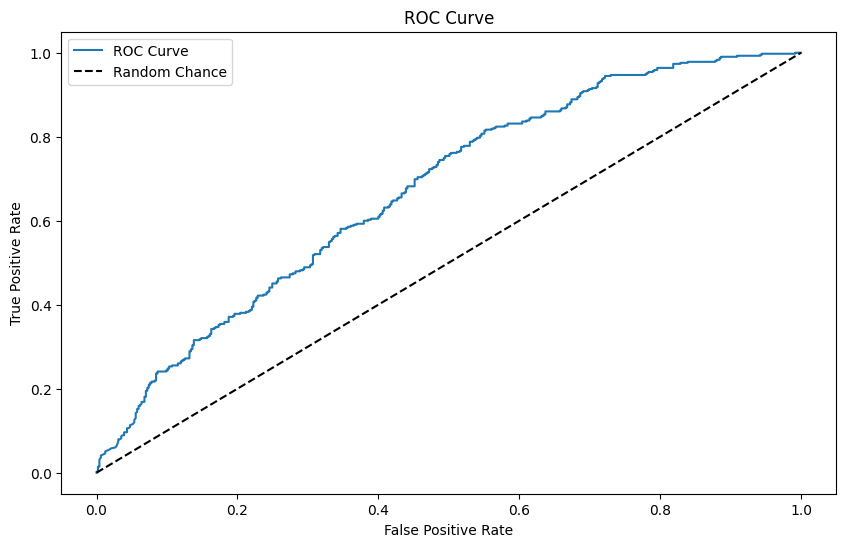

In [45]:
# let dig more into the results:
from sklearn.metrics import roc_curve
y_probs = ann.predict(X_test)
# Calculate FPR, TPR, and thresholds for the ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)
import matplotlib.pyplot as plt

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')  # random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

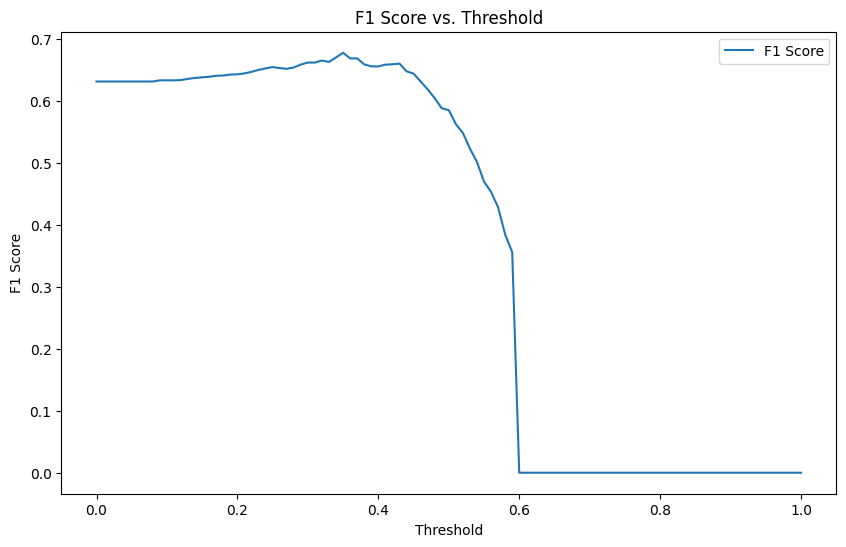

In [46]:
# Define a range of thresholds to evaluate
thresholds = np.linspace(0, 1, 101)

# Calculate F1 scores for each threshold
f1_scores = [f1_score(y_test, y_probs > threshold) for threshold in thresholds]

# Plotting F1 scores against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend(loc='best')
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


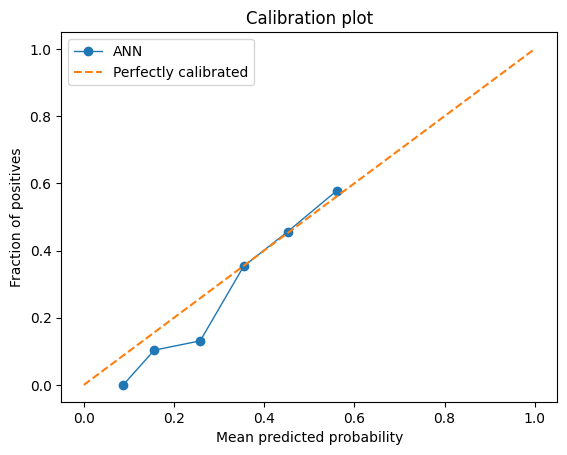

In [47]:
# let find the optimal threshold for balancing false positives and false negatives 
# to do that we are using calibration plot.
# Step 1: we should predict the probablities
y_probs = ann.predict(X_test)
# Step 2: Calculate Precision, Recall, and Thresholds
from sklearn.metrics import precision_recall_curve
# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# Step 3: Create a Calibration Plot

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

# Plotting the calibration curve
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='ANN')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.legend()
plt.show()